In [1]:
#!/usr/bin/python
#-*- coding: utf-8 -*-

# >.>.>.>.>.>.>.>.>.>.>.>.>.>.>.>.
# Licensed under the Apache License, Version 2.0 (the "License")
# You may obtain a copy of the License at
# http://www.apache.org/licenses/LICENSE-2.0

# --- File Name: eval_nav.py
# --- Creation Date: 17-02-2022
# --- Last Modified: Thu 17 Feb 2022 07:03:50 AEDT
# --- Author: Xinqi Zhu
# .<.<.<.<.<.<.<.<.<.<.<.<.<.<.<.<
"""
Visualize variation patterns.
"""
%matplotlib inline

import os
os.environ["CUDA_VISIBLE_DEVICES"]="2,3"

from typing import List
import pickle
import click
import matplotlib.pyplot as plt
import dnnlib
import numpy as np
import torch
import torch.nn.functional as F
import torch.nn as nn
import lpips
import IPython
from PIL import Image as ImagePIL
from IPython.display import Image, display

import legacy

In [4]:
os.listdir('/mnt/hpc_scratch')

['from_eva', 'stylegan2-ada-pytorch']

In [5]:
# pt
# navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/nav_eccv22_neig60_ffhq512/00000-ffhq512-z_30-lr_0.01-wals_0.3-prand_F-vart_s-mcont_1-dis_512-dic_3-mir_T-ldimg_T-ndup_1-sensor_alex-sensl_10-ftop_T-fdf_F-at_fixed-nt_fixedES-neig_60-afc_3-nfc_3-atl_16-atg_3-cont_0-pos_1-neg_1-div_0.1-ncol_2-dys_T-vars_0.5-kimg1000-batch28/network-snapshot-000880.pkl'
# bi
navigator_pkl = '/mnt/hpc_scratch/stylegan2-ada-pytorch/g-nav_cvpr22_nonod_ncol16_neig300_div_ffhq512/00003-ffhq512-z_64-lr_0.1-wals_1-prand_F-vart_s-sensor_alex-nsp_F-fdf_F-absd_F-vmul_T-nod_F-at_fixed-nt_fixedE-neig_300-afc_3-nfc_3-atl_16-atg_3-agst_1-xent_0-cont_1-pos_1-neg_1-div_0.01-ncol_16-dys_T-vars_0.5-kimg200-batch8-gan_network_pklffhq512/network-snapshot-000200.pkl'

device = torch.device('cuda:0')
gpu_ids = list(range(torch.cuda.device_count()))
with open(navigator_pkl, 'rb') as f:
    resume_data = pickle.load(f)
    M = resume_data['M'].requires_grad_(False)
M_ref = M.to(device)

generator_pkl = 'ffhq512'
print('Loading generator networks from "%s"...' % generator_pkl)
resume_specs = {
    'ffhq256':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res256-mirror-paper256-noaug.pkl',
    'ffhq512':     'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res512-mirror-stylegan2-noaug.pkl',
    'ffhq1024':    'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/ffhq-res1024-mirror-stylegan2-noaug.pkl',
    'celebahq256': 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/celebahq-res256-mirror-paper256-kimg100000-ada-target0.5.pkl',
    'lsundog256':  'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/transfer-learning-source-nets/lsundog-res256-paper256-kimg100000-noaug.pkl',
}

assert generator_pkl is not None
if generator_pkl in resume_specs:
    generator_pkl = resume_specs[generator_pkl] # predefined url

# gpu_ids = list(range(torch.cuda.device_count()))
# device = torch.device('cpu')
with dnnlib.util.open_url(generator_pkl) as f:
    G = legacy.load_network_pkl(f)['G_ema'].requires_grad_(False) # type: ignore

if len(gpu_ids) > 1:
    G = nn.DataParallel(G).to(device)
    G_ref = G.module
    G_mapping = nn.DataParallel(G_ref.mapping).to(device)
    G_synthesis = nn.DataParallel(G_ref.synthesis).to(device)
else:
    G_ref = G.to(device)
    G_mapping = G_ref.mapping.to(device)
    G_synthesis = G_ref.synthesis.to(device)
    
print(gpu_ids)
print('Done loading.')

Loading generator networks from "ffhq512"...
[0, 1]
Done loading.


In [7]:
outdir = '/mnt/hpc_scratch/stylegan2-ada-pytorch/real_edit'
os.makedirs(outdir, exist_ok=True)

In [8]:
plt.rcParams['figure.figsize'] = [10, 10]
# def show_norm(img):
#     img = (img - img.min()) / (img.max() - img.min())
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# def show_after_tanh(img):
#     img = (img + 1) / 2.
#     npimg = img.numpy()
#     plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

# def show(img):
#     show_norm(img)
#     #show_after_tanh(img)

# def clip_neg_show(img):
#     #img = img.abs()
#     img = img.relu()
#     show(img)

def imshow(img, surfix='0'):
    img = np.rint(img * 255).clip(0, 255).astype(np.uint8)
    img = ImagePIL.fromarray(np.transpose(img, (1,2,0)))
    img.save(os.path.join(outdir, f'tmp_{surfix}.jpg'))
    display(Image(filename=os.path.join(outdir, f'tmp_{surfix}.jpg')))

def show(img, im_range=[-1,1], **kwargs):
    img = (img - im_range[0]) / (im_range[1] - im_range[0])
    npimg = img.cpu().numpy()
    imshow(npimg, **kwargs)

In [50]:
def try_var_scale_ls(M, var_scale_ls, idx, used_dims, seed=0, truncation_psi=0.3):
    torch.random.manual_seed(seed)
    truncation_psi = 0.7
    z = torch.randn([1, G_ref.z_dim], device=device)
    c = torch.randn([1, G_ref.c_dim], device=device)
    w = G_ref.mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)
    dirs = M(w) # [b, nv_dim, num_ws, w_dim]
    print('dirs.shape', dirs.shape)
    w_1 = w - dirs[:, used_dims[idx]] * var_scale_ls[idx]
    w_2 = w + dirs[:, used_dims[idx]] * var_scale_ls[idx] # [b, num_ws, w_dim]
    print(idx)
    image = G_ref.synthesis(w_1, noise_mode='const')
    image_0 = G_ref.synthesis(w, noise_mode='const')
    image_2 = G_ref.synthesis(w_2, noise_mode='const')
    print(image.shape)

    show(torch.cat([image, image_0, image_2], dim=3)[0].cpu(), [-1,1], surfix=f'seed{seed}_dim{used_dims[idx]}_img')

In [10]:
truncation_psi = 0.5
def argsort_percept(G, M, n_samples_dim=100, batch_gpu=16):
    if len(gpu_ids) > 1:
        pnet = nn.DataParallel(lpips.LPIPS(net='alex', lpips=False)).to(device)
    else:
        pnet = lpips.LPIPS(net='alex', lpips=False).to(device)
    img_mean = torch.tensor([0.485, 0.456, 0.406]).to(device).view(1,3,1,1)
    img_std = torch.tensor([0.229, 0.224, 0.225]).to(device).view(1,3,1,1)
    rand_state = np.random.RandomState()
    percept_ls = []
    for i in range(M_ref.nv_dim):
        print('computing dim:', i)
        diff_ls_i = []
        for j in range(0, n_samples_dim, batch_gpu):
            b = batch_gpu if j+batch_gpu <= n_samples_dim else n_samples_dim-j

            z = torch.from_numpy(rand_state.randn(b, G_ref.z_dim)).to(device)
            c = torch.from_numpy(rand_state.randn(b, G_ref.c_dim)).to(device)
            w = G_mapping(z, c, truncation_psi=truncation_psi) # (b, num_ws, w_dim)

            #print(M.device)
            print(w.device)
            dirs = M(w) # [b, nv_dim, num_ws, w_dim]
            w_1 = w - dirs[:, i]
            w_2 = w + dirs[:, i] # [b, num_ws, w_dim]

            images = torch.cat([G_synthesis(w_1, noise_mode='const'),
                                G_synthesis(w_2, noise_mode='const')], dim=0) # (2b, c, h, w)
        
            # Normalize to fit model D
            # images_flat = images.view(2*b, -1)
            # img_min, img_max = images_flat.min(dim=-1)[0], images_flat.max(dim=-1)[0]
            # images = (images - img_min.view(2*b, 1, 1, 1)) / (img_max - img_min).view(2*b, 1, 1, 1)
            images = (images + 1.) / 2. # From [-1, 1] to [0, 1]
            images = (images - img_mean) / img_std
            
            diff = pnet(images[:b], images[b:]).squeeze() # [b]
            diff_ls_i.append(diff.to('cpu'))
        print(diff_ls_i)
        diff_i_sum = torch.cat(diff_ls_i, dim=0).sum()
        percept_ls.append(diff_i_sum)
    percept = torch.tensor(percept_ls, device=device)
    _, idx_sort = torch.sort(percept, descending=True)
    return idx_sort

In [11]:
# used_dims = argsort_percept(G, M, n_samples_dim=20, batch_gpu=16)
used_dims = [38, 22, 20, 48, 13, 29, 19, 45, 24, 26,  2, 50, 42, 44, 31, 41, 21, 23,
        40, 25, 37, 28, 59, 51, 18, 63, 39, 30,  9, 12,  3,  1, 54, 43, 55,  8,
        36, 34, 14, 27, 53, 17,  6, 16, 61, 10,  0, 60, 33,  4, 35, 62, 56, 11,
        57, 47, 52, 49, 46,  7, 32,  5, 15, 58]

[38, 22, 20, 48, 13, 29, 19, 45, 24, 26, 2, 50, 42, 44, 31, 41, 21, 23, 40, 25, 37, 28, 59, 51, 18, 63, 39, 30, 9, 12, 3, 1, 54, 43, 55, 8, 36, 34, 14, 27, 53, 17, 6, 16, 61, 10, 0, 60, 33, 4, 35, 62, 56, 11, 57, 47, 52, 49, 46, 7, 32, 5, 15, 58]
dirs.shape torch.Size([1, 64, 16, 512])
2
torch.Size([1, 3, 512, 512])


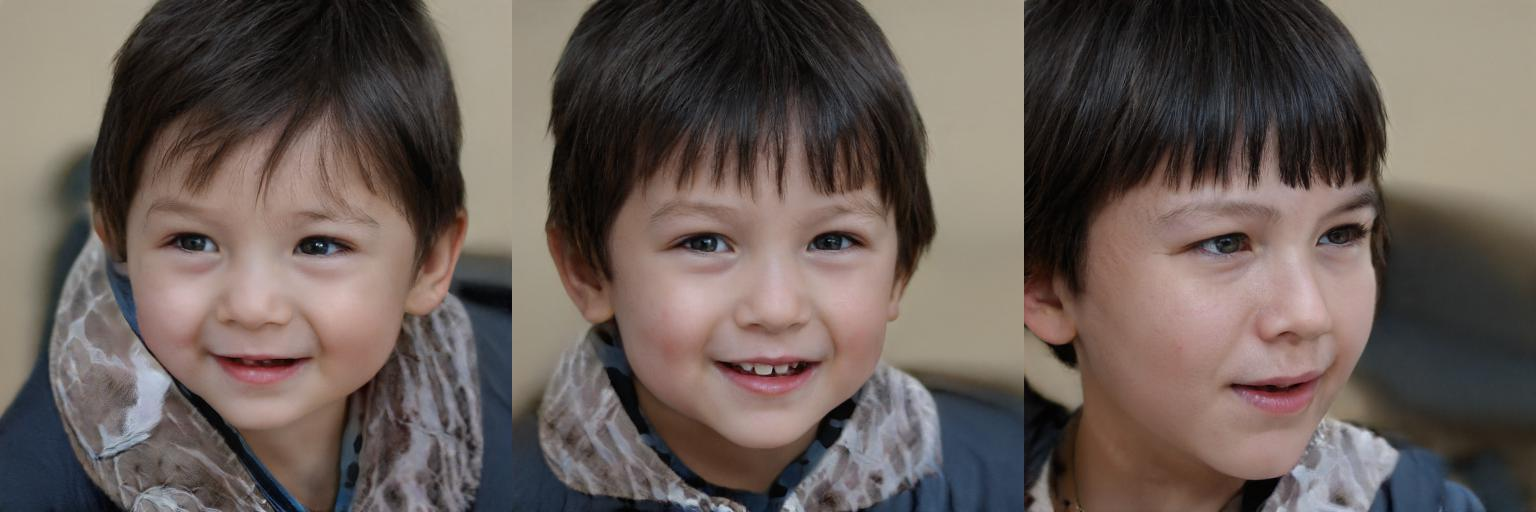

In [118]:
# used_dims = [0,2,4,5,9,10,11,12,14,16,18,19,22,24]
print(used_dims)
var_scale_ls = [0.5,0.5,1,1.5,0.7,
                0.3,0.4,0.3,0.3,0.8,
                1,0.3,0.8,0.5,0.5,
                1,0.5,0.8,0.8,0.8,
                0.8,0.5,0.3,0.5,0.5,
                0.5,0.7,0.6,0.4,0.3,
                0.3,0.5,0.3,0.4,0.4,
                0.3,0.3,0.5,0.2,0.2,
                0.6,1,0.9,0.5,0.4,
                1,0.5,0.8,3,1,
                3,0.7,3,0.8,2,
                1,1,1,1,1,
                2,1,1,1,
               ]
good_dims = [2,5,6,7,9,11,12,13,14,16,17,18,19,20,21,22,
            23,26,27,28,29,30,32,33,34,36,38,39,40,42,
           44,46,47,50,51,54,]
attr_names = ['head_rotation', 'ambient', 'race', 'light', 'hair_length', 'brightness', 'elevation', 
              'face_length_1', 'hair_color', 'background_frequency', 'right_shoulder', 'left_shoulder', 
              'hair_thickness', 'fatness', 'gender', 'background_blue', 'face_yellow', 'fringe',
              'face_length_2', 'glasses', 'chin_size', 'clothes_white', 'clothes_red', 'hair_vertical',
              'nose_length', 'eye_open', 'smile', 'eyebrow', 'clothes_wear', 'sketch', 'yell_open',
              'smile_open', 'laugh_open_1', 'hair_style', 'laugh_open_2', 'skin_type']
# 21: gender;
idx = 2
#for idx in range(14):
# seed 235 is a baby
seed = 252
try_var_scale_ls(M, var_scale_ls, idx, used_dims, seed=seed)

In [11]:
from edit_image import project

In [12]:
real_imgs_dir = '/mnt/hpc_hdd_2/repo_results/stylegan2/projection_real_images/'
real_names = ['gates.png', 'lecun.jpeg', 'ng.jpeg', 'obama1.png', 'thor.png', 'gal_gadot.png', 'reals0028.png']
real_name = real_names[0]

# for real_name in real_names:
proj_outdir = os.path.join(outdir, os.path.splitext(real_name)[0])
os.makedirs(proj_outdir, exist_ok=True)
target = os.path.join(real_imgs_dir, real_name)
# project_and_save(target, proj_outdir)

In [13]:
def project_and_save(target, proj_outdir):
    target_pil = ImagePIL.open(target).convert('RGB')
    w, h = target_pil.size
    s = min(w, h)
    target_pil = target_pil.crop(((w - s) // 2, (h - s) // 2, (w + s) // 2, (h + s) // 2))
    target_pil = target_pil.resize((G_ref.img_resolution, G_ref.img_resolution), ImagePIL.LANCZOS)
    
    target_uint8 = np.array(target_pil, dtype=np.uint8)
    projected_w_steps = project(
        G_ref,
        target=torch.tensor(target_uint8.transpose([2, 0, 1]), device=device),
        num_steps=1000,
        device=device,
        verbose=True
    )
    projected_w = projected_w_steps[-1].unsqueeze(0) # (1, num_ws, w_dim)
    np.savez(f'{proj_outdir}/projected_w.npz', w=projected_w.cpu().numpy())
    target_pil.save(f'{proj_outdir}/target.png')
    img = G_ref.synthesis(projected_w, noise_mode='const')
    img = (img + 1) / 2 * 255 # [1, c, h, w]
    npimg = img.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    ImagePIL.fromarray(npimg, 'RGB').save(f'{proj_outdir}/proj.png')

In [14]:
def imshow_edit(img, outdir=None, surfix='0'):
    img = np.rint(img * 255).clip(0, 255).astype(np.uint8)
    img = ImagePIL.fromarray(np.transpose(img, (1,2,0)))
    img.save(os.path.join(outdir, f'tmp_{surfix}.jpg'))
    display(Image(filename=os.path.join(outdir, f'tmp_{surfix}.jpg')))

def show_edit(img, im_range=[-1,1], **kwargs):
    img = (img - im_range[0]) / (im_range[1] - im_range[0])
    npimg = img.cpu().numpy()
    imshow_edit(npimg, **kwargs)

In [15]:
print(projected_w_steps.shape)

NameError: name 'projected_w_steps' is not defined

In [16]:
def edit_image_w(M, w, var_scale_ls, attr_names, img_name, sorted_idx,
                 good_dims, idx, proj_outdir, manual_scale=1):
    dirs = M(w) # [1, nv_dim, num_ws, w_dim]
    print('dirs.shape', dirs.shape)
    w_1 = w - dirs[:, sorted_idx[good_dims[idx]]] * manual_scale * var_scale_ls[good_dims[idx]]
    w_11 = w - 0.5 * dirs[:, sorted_idx[good_dims[idx]]] * manual_scale * var_scale_ls[good_dims[idx]]
    w_21 = w + 0.5 * dirs[:, sorted_idx[good_dims[idx]]] * manual_scale * var_scale_ls[good_dims[idx]]
    w_2 = w + dirs[:, sorted_idx[good_dims[idx]]] * manual_scale * var_scale_ls[good_dims[idx]] # [b, num_ws, w_dim]
    print(idx)
    image_1 = G_ref.synthesis(w_1, noise_mode='const')
    image_11 = G_ref.synthesis(w_11, noise_mode='const')
    image_0 = G_ref.synthesis(w, noise_mode='const')
    image_21 = G_ref.synthesis(w_21, noise_mode='const')
    image_2 = G_ref.synthesis(w_2, noise_mode='const')
    print(image_1.shape)

    show_edit(torch.cat([image_1, image_11, image_0, image_21, image_2], dim=3)[0].cpu(), [-1,1],
         outdir=proj_outdir, surfix=
              f'dim{sorted_idx[good_dims[idx]]}_{attr_names[idx]}_{img_name}_scale{manual_scale}')

real_names: ['gates.png', 'lecun.jpeg', 'ng.jpeg', 'obama1.png', 'thor.png', 'gal_gadot.png', 'reals0028.png']
var_scale_ls: [0.5, 0.5, 1, 1.5, 0.7, 0.3, 0.4, 0.3, 0.3, 0.5, 1, 0.3, 0.5, 0.5, 0.5, 1, 0.5, 0.8, 0.8, 0.8, 0.8, 0.4, 0.3, 0.5, 0.5, 0.5, 0.7, 0.6, 0.4, 0.3, 0.3, 0.5, 0.3, 0.4, 0.4, 0.3, 0.3, 0.5, 0.2, 0.2, 0.6, 1, 0.9, 0.5, 0.4, 1, 0.5, 0.8, 3, 1, 3, 0.7, 3, 0.8, 2, 1, 1, 1, 1, 1, 2, 1, 1, 1]
attr_names: ['head_rotation', 'ambient', 'race', 'light', 'hair_length', 'brightness', 'elevation', 'face_length_1', 'hair_color', 'background_frequency', 'right_shoulder', 'left_shoulder', 'hair_thickness', 'fatness', 'gender', 'background_blue', 'face_yellow', 'fringe', 'face_length_2', 'glasses', 'chin_size', 'clothes_white', 'clothes_red', 'hair_vertical', 'nose_length', 'eye_open', 'smile', 'eyebrow', 'clothes_wear', 'sketch', 'yell_open', 'smile_open', 'laugh_open_1', 'hair_style', 'laugh_open_2', 'skin_type']
good_dims [2, 5, 6, 7, 9, 11, 12, 13, 14, 16, 17, 18, 19, 20, 21, 22, 

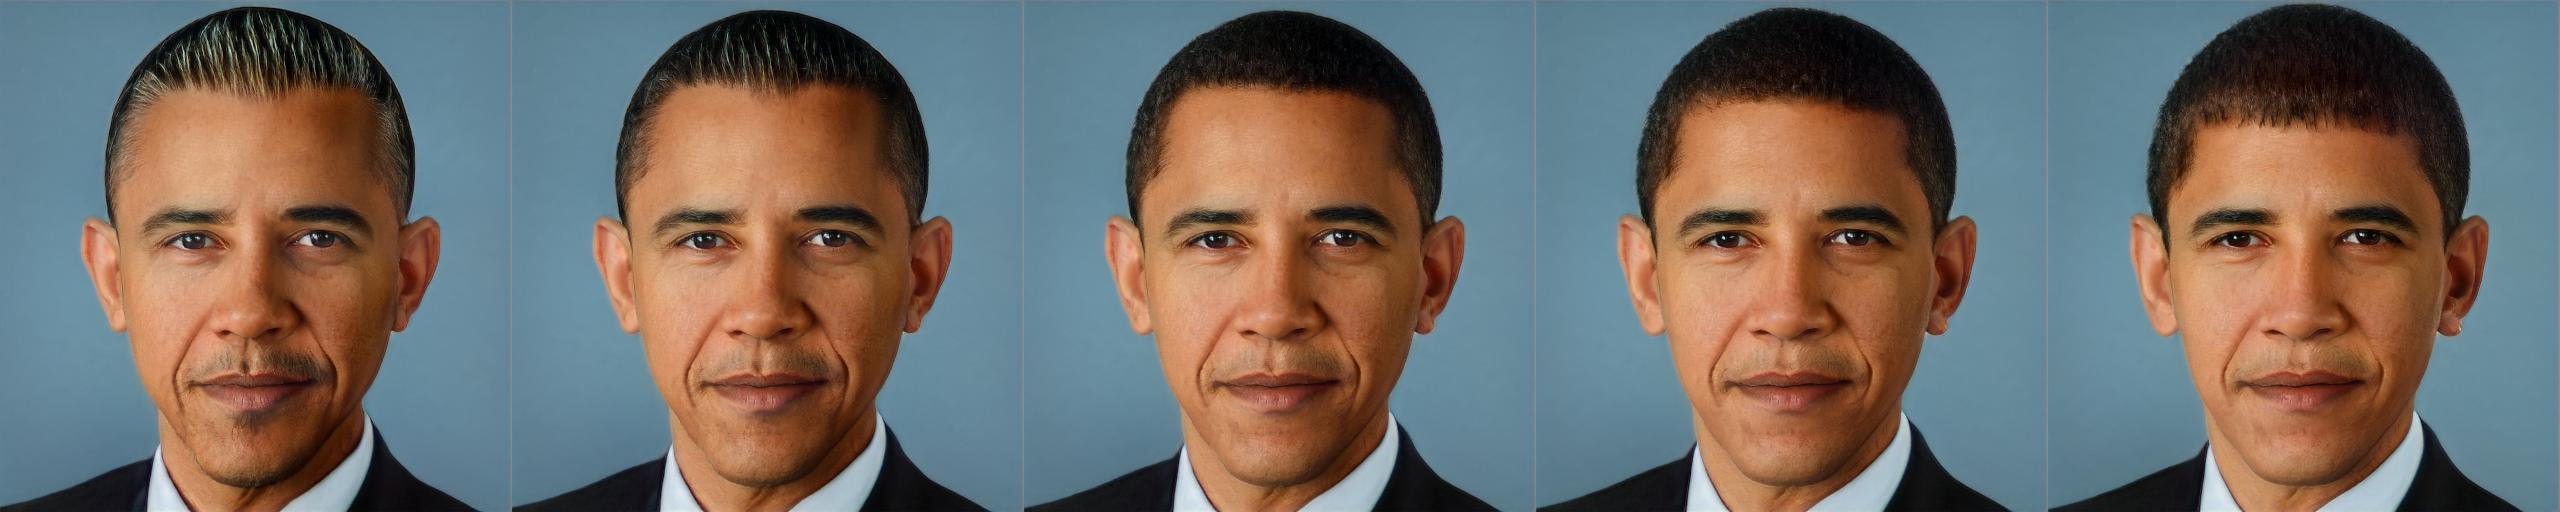

In [25]:
real_imgs_dir = '/mnt/hpc_hdd_2/repo_results/stylegan2/projection_real_images/'
real_names = ['gates.png', 'lecun.jpeg', 'ng.jpeg', 'obama1.png', 'thor.png', 'gal_gadot.png', 'reals0028.png']
real_name = real_names[3]
manual_scale = 6
edit_good_idx = 23

# for real_name in real_names:
#     proj_outdir = os.path.join(outdir, os.path.splitext(real_name)[0])

#     projected_w = np.load(f'{proj_outdir}/projected_w.npz')['w']
#     projected_w = torch.tensor(projected_w).to(device)
#     print(projected_w.shape)

#     print('real_names:', real_names)
#     print('var_scale_ls:', var_scale_ls)
#     print('attr_names:', attr_names)
#     print('good_dims', good_dims)
#     edit_good_idx = -9

#     for edit_good_idx in range(len(good_dims)):
#         for manual_scale in [1, 2, 3, 4]:
#             edit_image_w(M, projected_w, var_scale_ls, attr_names, os.path.splitext(real_name)[0],
#                          used_dims, good_dims, edit_good_idx, proj_outdir, manual_scale)

print('real_names:', real_names)
print('var_scale_ls:', var_scale_ls)
print('attr_names:', attr_names)
print('good_dims', good_dims)

proj_outdir = os.path.join(outdir, os.path.splitext(real_name)[0])
projected_w = np.load(f'{proj_outdir}/projected_w.npz')['w']
projected_w = torch.tensor(projected_w).to(device)
edit_image_w(M, projected_w, var_scale_ls, attr_names, os.path.splitext(real_name)[0],
                     used_dims, good_dims, edit_good_idx, proj_outdir, manual_scale)